In [1]:
import scanpy as sc
import squidpy as sq

from util import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [ ]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

In [48]:
test = sc.read_h5ad('F://Rep11_MOB_ST.h5ad')
position_list = list(test.obs.index.str.split('x'))
arr = np.array(position_list, dtype=np.float32).reshape(len(position_list), 2)
test.obs['fig_x'] = arr[:,0] * 1000
test.obs['fig_y'] = arr[:,1] * 1000

F:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


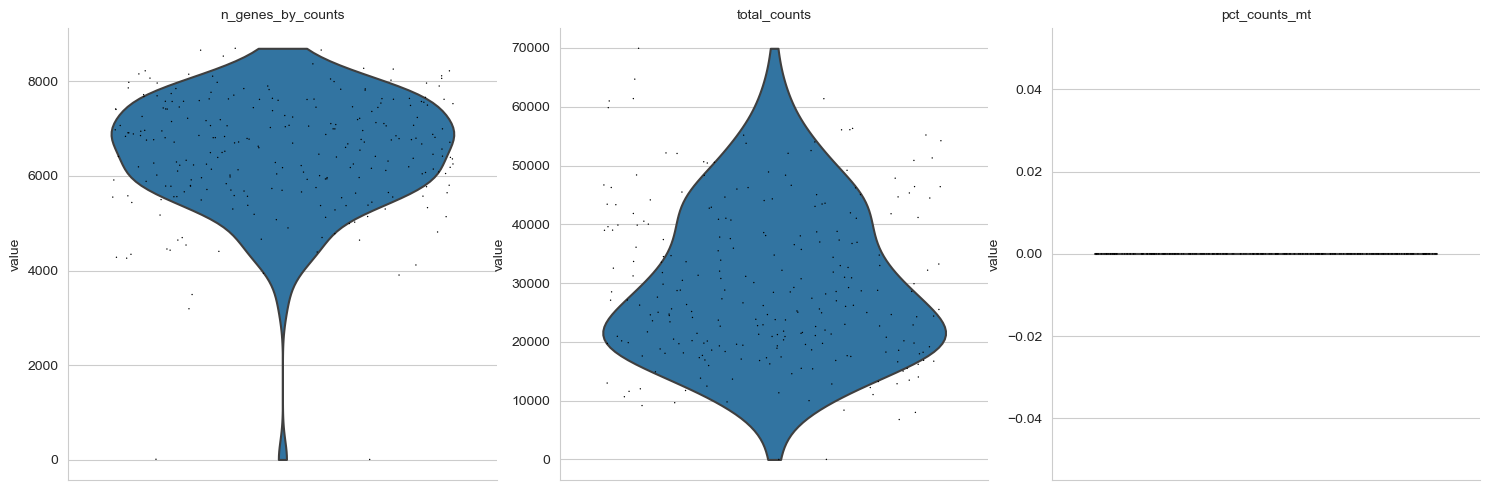

In [49]:
h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata = test
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [50]:
sc.pp.filter_genes(adata, min_cells=50)
adata

AnnData object with n_obs × n_vars = 262 × 9868
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'fig_x', 'fig_y', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    obsm: 'spatial'

In [ ]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

In [51]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)

In [53]:
gene_list = adata.var[adata.var['highly_variable']==True].index
len(gene_list)

2206

In [313]:
paper = ['Rab3b','Necab2','Tspan7','Cdr1','Slc17a7','4933405L10Rik','Taf7l','Gna14','Olfr635','Pmepa1','Pcp4','Apc','Rbfox3','Penk','Frzb','Fabp7','Slc6a11','Apod','S100a5','Arhgap33','Cplx1','Trnp1','Marcks','Atp1b1','Vtn','Trak2','Igf1','Gabra1','Igfbp2','Lpar1','Omp','Kif5b','Sorbs1','Cck','Nr2f2','Scd1','Cpe','Aqp4','Doc2g','Slc1a2','Nrgn','Cdhr1','Mcf2l','Kctd12','Unc13c','Foxd3','Prokr2','Gng13','Kcnh3','Camk2b','Baiap2','Ccnd1','Gpsm1','Pbx1','Sepp1','Apoe','Tubb2b','Ncdn','Glul','Sash1','Ptgds','Sparcl1','Mbp','Nrsn1','Igfbp5','Ptn','Sfrp5']

In [ ]:
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
len(gene_list)

In [ ]:
gmm_dict = fit_gmms(adata, gene_list, n_comp=10, thread=4)

100%|██████████| 2206/2206 [00:00<00:00, 61281.81it/s]


In [11]:
arr = build_distance_array(gmm_dict)

Processing: 100%|██████████| 3269/3269 [3:01:26<00:00,  3.33s/it]  


In [13]:
arr

array([[ 0.        ,  5.89606025,  7.27230303, ...,  9.99999871,
         9.99999686,  9.99999779],
       [ 5.89606025,  0.        ,  7.8098502 , ...,  9.99999866,
         9.99999742,  9.99999846],
       [ 7.27230303,  7.8098502 ,  0.        , ...,  8.99999892,
         9.99999747,  9.99999671],
       ...,
       [ 9.99999871,  9.99999866,  8.99999892, ...,  0.        ,
        10.        ,  5.00000007],
       [ 9.99999686,  9.99999742,  9.99999747, ..., 10.        ,
         0.        , 10.        ],
       [ 9.99999779,  9.99999846,  9.99999671, ...,  5.00000007,
        10.        ,  0.        ]])

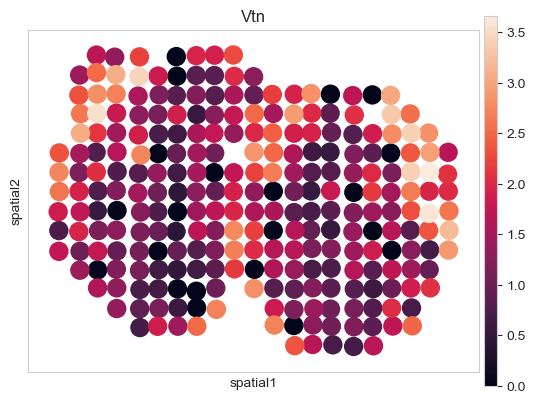

In [14]:
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              color=list(['Vtn']))

In [ ]:
from sklearn.manifold import MDS
distance_matrix=arr
# distance_matrix为距离矩阵
mds = MDS(n_components=10, dissimilarity='precomputed')
embedding = mds.fit_transform(distance_matrix)

In [16]:
from sklearn.cluster import KMeans
# embedding为映射矩阵，n_clusters为聚类数目
kmeans = KMeans(n_clusters=10, random_state=0).fit(embedding)
# 获取聚类标签
labels = kmeans.labels_
labels

array([3, 3, 8, ..., 2, 6, 2])

C:\Users\pssun\AppData\Local\Temp\ipykernel_5576\2061655789.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  color=list(df[df['labels']==6]['gene'][:15]))


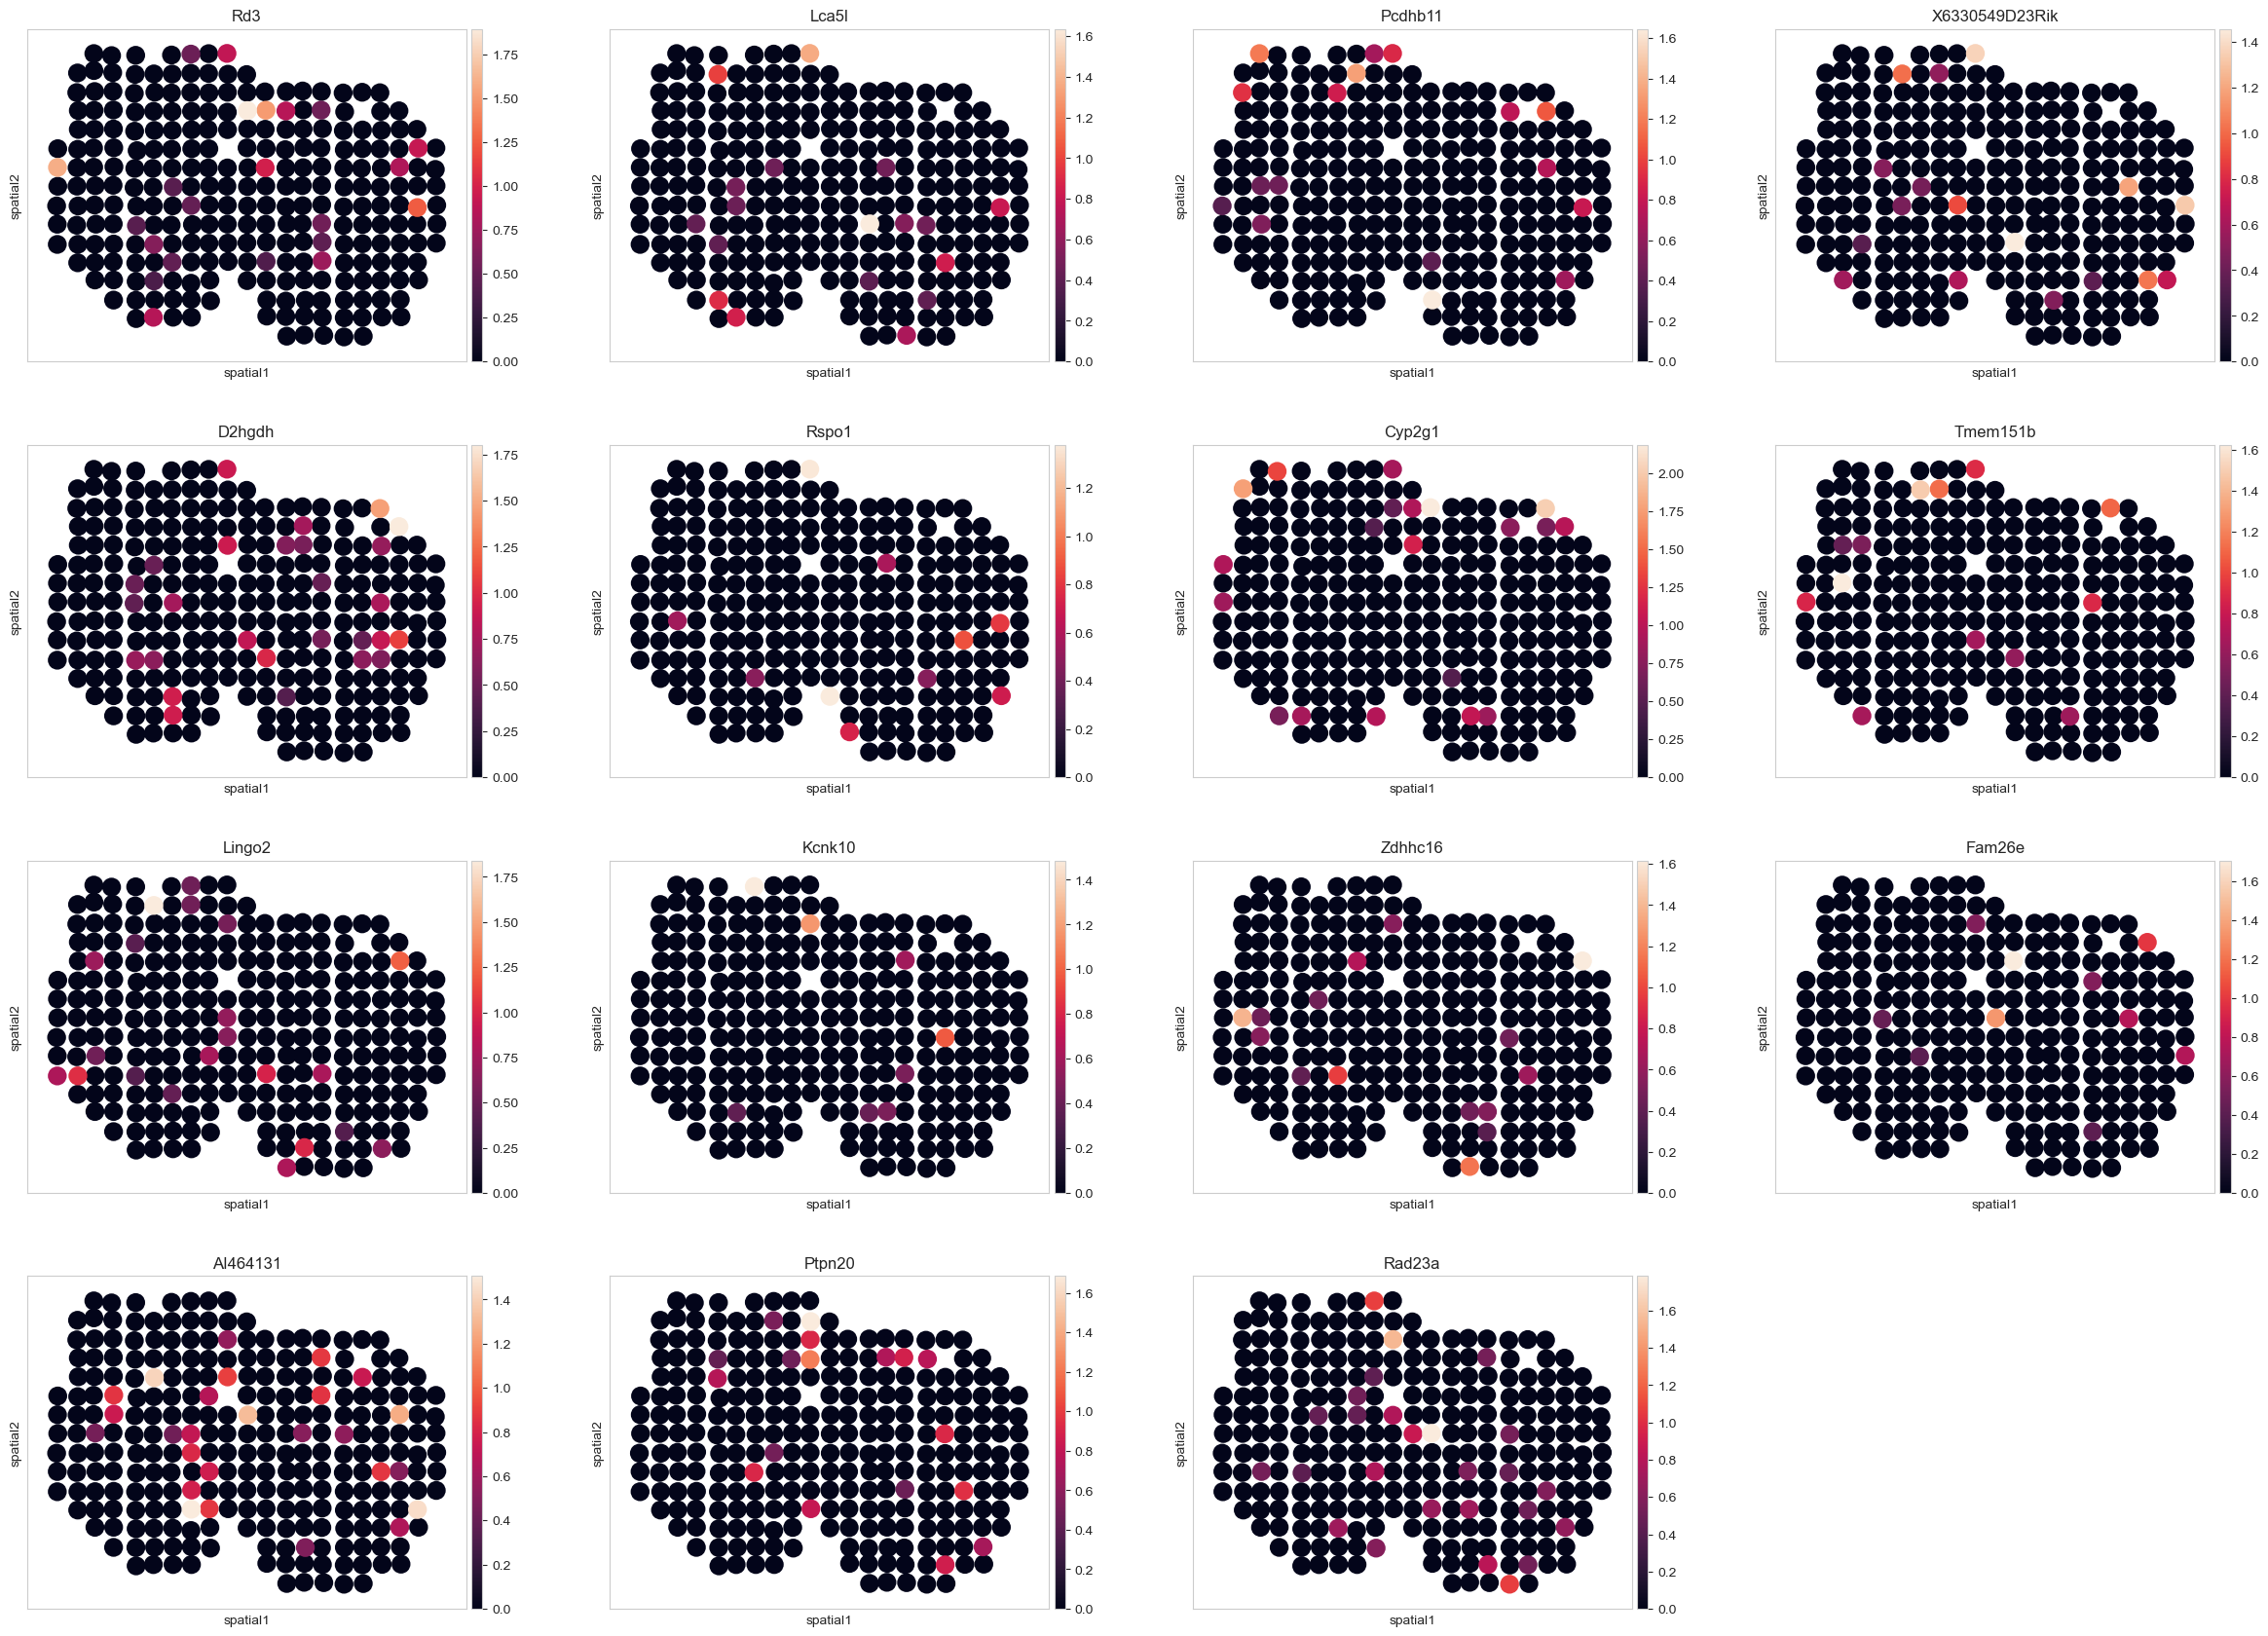

In [43]:
df = pd.DataFrame({'gene':list(gmm_dict.keys()), 'labels':list(kmeans.labels_)})
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              color=list(df[df['labels']==]['gene'][:15]))

In [ ]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro','tcap', 'mt2'])

In [ ]:
gmm1 = fit_gmm(adata, 'mt2')
gmm2 = fit_gmm(adata, 'ptpro')

In [ ]:
view_gmm(gmm2, '2d')